# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 852.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [5]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 186
The number of columns: 494


## Pre-processing
Feature Cleaning:

1. Loading the full dataset from Excel.
2. Identifying and removing features with excessive outliers using the IQR method.
3. Winsorizing (capping) extreme values in the remaining features to reduce their influence.
4. Printing the new dataset dimensions and how many features were removed.

In [4]:
# Imports
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from pathlib import Path

current_dir = Path.cwd()
dir_results = current_dir / 'Results'

# Load the dataset from an Excel file into a DataFrame
df = pd.read_excel('FullDataset.xlsx')
print(f"Original shape: {df.shape}")  # Shows initial number of rows and columns (samples, features)

# Keep only the numeric columns (e.g., float, int) for outlier analysis
numeric_df = df.select_dtypes(include='number')

# Drop duplicate columns if any exist
numeric_df = numeric_df.loc[:, ~numeric_df.columns.duplicated()]
print(f"Shape after removing duplicates: {numeric_df.shape}")

# Dictionary to store number of outliers found in each column
outlier_counts = {}

# Loop over all numeric features to detect outliers
for col in numeric_df.columns:
    Q1 = numeric_df[col].quantile(0.25)     # First quartile (25th percentile)
    Q3 = numeric_df[col].quantile(0.75)     # Third quartile (75th percentile)
    IQR = Q3 - Q1                           # Interquartile range
    lower_bound = Q1 - 5 * IQR              # Conservative lower outlier threshold
    upper_bound = Q3 + 5 * IQR              # Conservative upper outlier threshold

    # Identify outliers and count them
    outliers = numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

# Create a DataFrame from the dictionary to make it easy to sort/view
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outlier_count'])
outlier_df = outlier_df.sort_values(by='outlier_count', ascending=False)

# Define a threshold: if a feature has more than 17 outliers, we consider it too noisy
threshold = 17
features_to_drop = outlier_df[outlier_df['outlier_count'] > threshold].index.tolist()

# Drop those features from the original DataFrame
df = df.drop(columns=features_to_drop)

# Identify the features that are still allowed (with 17 or fewer outliers)
features_to_winsorize = outlier_df[outlier_df['outlier_count'] <= threshold].index.tolist()

# Apply outlier capping to these "acceptable" features
for feature in features_to_winsorize:
    if feature in df.columns:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 5 * IQR
        upper_bound = Q3 + 5 * IQR

        # Clip values that fall outside the acceptable range
        df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)

# Print new shape of the cleaned dataset
print(f"Shape after cleaning: {df.shape}")
print(f"Removed {len(features_to_drop)} features with more than {threshold} outliers.")

numeric_df = df.select_dtypes(include='number').drop(columns=['label'])
X_clean = numeric_df.values

print(f"Shape before removing constant features: {X_clean.shape}")

# Verwijder constant features (met variantie == 0)
selector = VarianceThreshold(threshold=0.0)
X_clean = selector.fit_transform(X_clean)
y_clean = df['label'].values

print(f"Shape after removing constant features: {X_clean.shape}")



Original shape: (186, 494)
Shape after removing duplicates: (186, 494)
Shape after cleaning: (186, 487)
Removed 7 features with more than 17 outliers.
Shape before removing constant features: (186, 486)
Shape after removing constant features: (186, 452)


## Experimental Setup

![Example Image](figure.jpg)

This function performs nested cross-validation for robust model evaluation and hyperparameter tuning using:
- Outer loop: Evaluates generalization performance
- Inner loop: Tunes hyperparameters using GridSearchCV
- RFECV: Performs recursive feature elimination within each outer fold

It returns performance scores, selected hyperparameters, and feature selection masks across multiple repeated trials

In [5]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif

# difficult nested score to see best params. Perform grid-search with nested cross-validation for hyperparameter tuning
def safe_f_classif(X, y):
    """Wrapper around sklearn's _f_classif to handle divide-by-zero."""
    with np.errstate(divide='ignore', invalid='ignore'):
        return f_classif(X, y)
    
def nested_cross_validation(NUM_TRIALS : int, clf_class, param_grid : dict, X : np.ndarray, y : np.ndarray, mask = None) -> tuple:
    """
    Perform nested cross-validation for hyperparameter tuning.
    This function uses RFECV for feature selection and SelectKBest for feature selection.
    It evaluates the model using accuracy as the scoring metric.
    
    Parameters:
    - NUM_TRIALS: Number of trials to run
    - clf_class: The machine learning classifier to evaluate
    - param_grid: Hyperparameter grid for GridSearchCV
    - X: Feature matrix
    - y: Target vector
    
    Returns:
    - nested_scores: Array of scores from each trial
    - df_best_params: DataFrame of best parameters for each trial
    - df_masks: DataFrame of all feature selection masks
    """
    
    nested_scores = np.zeros(NUM_TRIALS)      # To store average scores per trial
    all_best_params = []                      # To store best hyperparameters per trial
    all_feature_masks = []                    # To store feature selection masks per trial

    for i in range(NUM_TRIALS):
        # Outer and inner stratified cross-validation splitters
        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        RFECV_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i+1000)
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i+2000)

        # Store the best parameters and scores for each outer fold
        best_params = []     # For storing best parameters for each outer fold
        outer_scores = []    # AUC scores per outer fold
        trial_masks = []     # Feature selection masks per outer fold

        k = 0
        for train_idx, test_idx in outer_cv.split(X, y):
            k += 1
            print(f"Outer fold {k}")
            # Split data into training and test for this outer fold
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Feature selection via SelectKBest using the outer CV folds
            # SelectKBest is used to select the top k features based on ANOVA F-value
            # You can delete this if you want to use all features, computation time will be longer!
            selector_kbest = SelectKBest(score_func=safe_f_classif, k=100)              
            
            # Fit the selector on the training data, not the entire dataset
            # This can be deteled, but it will take longer to compute!
            # Fit SelectKBest on outer training set
            # and transform both the training and test sets
            selector_kbest.fit(X_train, y_train)  # Fit SelectKBest on outer training set
            X_train = selector_kbest.transform(X_train)  # Transform outer training set 
            X_test = selector_kbest.transform(X_test)  # Transform outer test set        
            
            if mask is None:
            # Feature selection via RFECV using the inner CV folds
                selector_RFECV = RFECV(
                    estimator=RandomForestClassifier(),
                    step=1,
                    cv=RFECV_cv,
                    scoring='accuracy'
                    )


                selector_RFECV.fit(X_train, y_train)  # Fit RFECV on outer training set  
                trial_masks.append(selector_RFECV.support_)  # Save which features were kept
                print("RFECV done")
                # Reduce training and test sets to selected features
                X_train = selector_RFECV.transform(X_train)
                X_test = selector_RFECV.transform(X_test)
            else:
                # Use the provided mask to select features
                
                mask_used = mask[f'outer_{k}'].values[i-1]

                X_train = X_train[:, mask_used]
                X_test = X_test[:, mask_used]
                trial_masks.append(mask_used)
            
            # Build a fresh pipeline for each fold
            pipeline = Pipeline([
                ("scaler", MinMaxScaler()),       # Normalize features to [0, 1]
                ("clf_class", clf_class)          # Insert model
            ])
                        
            # Create a new GridSearchCV for each inner fold
            grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring="accuracy", n_jobs=-1)
            
            # Fit GridSearchCV on the training data
            grid_search.fit(X_train, y_train)
            
            # Get the best model from inner CV
            best_model = grid_search.best_estimator_
            best_model.fit(X_train, y_train)  # Fit the best model on the outer training set

            # Evaluate the best model on the outer test fold
            y_pred = best_model.predict(X_test)
            outer_score = accuracy_score(y_test, y_pred)
            # Append the best parameters and outer score
            best_params.append(grid_search.best_params_)
            outer_scores.append(outer_score)
        
        # Store the mean score for this trial
        nested_scores[i] = np.mean(outer_scores)
        all_best_params.append([i, best_params])
        all_feature_masks.append([i, trial_masks])

    # Format best params and feature masks into DataFrames
    df_best_params = pd.DataFrame([best_params for _, best_params in all_best_params], columns=["outer_1", "outer_2", "outer_3", "outer_4", "outer_5"])
    df_masks = pd.DataFrame([trial_masks for _, trial_masks in all_feature_masks], columns=["outer_1", "outer_2", "outer_3", "outer_4", "outer_5"])


    # Print results
    print(f"Average performance across {NUM_TRIALS} trials: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")

    return nested_scores, df_best_params, df_masks


# Code for the KNN classifier
This code is used to perform nested cross-validation for hyperparameter tuning of a K-Nearest Neighbors (KNN) classifier.
It includes feature selection using SelectKBest and RFECV, and it evaluates the model's performance using accuracy as the scoring metric.

In [6]:
# Imports
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'clf_class__n_neighbors': [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
}

clf_class = KNeighborsClassifier()

# NUM_TRIALS = 1 -> could be changed when stronger computer available
nested_scores_knn, df_best_params_knn, df_masks_knn = nested_cross_validation(1,clf_class, param_grid, X_clean, y_clean)

# Save the results to CSV files
df_best_params_knn.to_csv(dir_results / "best_params_knn.csv", index=False)
df_masks_knn.to_csv(dir_results / 'masks_knn.csv', index=False)

for i in df_masks_knn:
    print(f"{i}: {df_masks_knn[i].values[0].sum()} features selected")

best_params_knn_ravel= pd.Series(df_best_params_knn.values.ravel())
best_params_knn_ravel.value_counts()[0:10]

Outer fold 1
RFECV done
Outer fold 2
RFECV done
Outer fold 3
RFECV done
Outer fold 4
RFECV done
Outer fold 5
RFECV done
Average performance across 1 trials: 0.6883 ± 0.0000
outer_1: 89 features selected
outer_2: 33 features selected
outer_3: 45 features selected
outer_4: 57 features selected
outer_5: 93 features selected


{'clf_class__n_neighbors': 21}    1
{'clf_class__n_neighbors': 15}    1
{'clf_class__n_neighbors': 23}    1
{'clf_class__n_neighbors': 17}    1
{'clf_class__n_neighbors': 12}    1
Name: count, dtype: int64

# Code for the Naive Bayes
This code is used to perform nested cross-validation for hyperparameter tuning of a Naive Bayes classifier.
It includes feature selection using SelectKBest and RFECV, and it evaluates the model's performance using accuracy as the scoring metric.

In [ ]:
# Imports
from sklearn.naive_bayes import GaussianNB

param_grid = {
    'clf_class__var_smoothing': [1*10**-12, 1*10**-11, 1*10**-10, 1*10**-9, 1*10**-8, 1*10**-7, 1*10**-6, 1*10**-5, 1*10**-4, 1*10**-3, 1*10**-2, 1*10**-1],
}

clf_class = GaussianNB()

# NUM_TRIALS = 1 -> could be changed when stronger computer available
nested_scores_naive, df_best_params_naive, df_masks_naive = nested_cross_validation(1,clf_class, param_grid, X_clean, y_clean, df_masks_knn)

# Save the results to CSV files
df_best_params_naive.to_csv(dir_results / "best_params_naive.csv", index=False)
df_masks_naive.to_csv(dir_results / 'masks_naive.csv', index=False)

for i in df_masks_naive:
    print(f"{i}: {df_masks_naive[i].values[0].sum()} features selected")

best_params_naive_ravel= pd.Series(df_best_params_naive.values.ravel())
best_params_naive_ravel.value_counts()[0:10]

Outer fold 1
Outer fold 2
Outer fold 3
Outer fold 4
Outer fold 5
Average performance across 1 trials: 0.6667 ± 0.0000
outer_1: 89 features selected
outer_2: 33 features selected
outer_3: 45 features selected
outer_4: 57 features selected
outer_5: 93 features selected


{'clf_class__var_smoothing': 1e-12}    3
{'clf_class__var_smoothing': 0.1}      2
Name: count, dtype: int64

# Code for the Random Forest Classifier
This code is used to perform nested cross-validation for hyperparameter tuning of a Random Forest classifier.
It includes feature selection using SelectKBest and RFECV, and it evaluates the model's performance using accuracy as the scoring metric.

In [8]:
# Imports
# Imports
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'clf_class__n_estimators': [30, 50, 70],
    'clf_class__max_depth': [3, 5, 7],
    'clf_class__max_features': [0.3, 0.5, 0.9],
    # 'clf_class__min_samples_split': [7, 11, 15],
    # 'clf_class__min_samples_leaf': [1, 2, 3],
    # 'clf_class__class_weight': ['balanced', None],
    # 'clf_class__criterion': ['gini', 'entropy'],
}

clf_class = RandomForestClassifier()

# NUM_TRIALS = 1 -> aanpassen
nested_scores_rf, df_best_params_rf, df_masks_rf = nested_cross_validation(1,clf_class, param_grid, X_clean, y_clean, df_masks_knn)

# Save the results to CSV files
df_best_params_rf.to_csv(dir_results / "best_params_rf.csv", index=False)
df_masks_rf.to_csv('masks_rf.csv', index=False)

for i in df_masks_rf:
    print(f"{i}: {df_masks_rf[i].values[0].sum()} features selected")

best_params_rf_ravel= pd.Series(df_best_params_rf.values.ravel())
best_params_rf_ravel.value_counts()[0:10]

Outer fold 1
Outer fold 2
Outer fold 3
Outer fold 4
Outer fold 5
Average performance across 1 trials: 0.6990 ± 0.0000
outer_1: 89 features selected
outer_2: 33 features selected
outer_3: 45 features selected
outer_4: 57 features selected
outer_5: 93 features selected


{'clf_class__max_depth': 5, 'clf_class__max_features': 0.5, 'clf_class__n_estimators': 50}    1
{'clf_class__max_depth': 5, 'clf_class__max_features': 0.5, 'clf_class__n_estimators': 30}    1
{'clf_class__max_depth': 7, 'clf_class__max_features': 0.3, 'clf_class__n_estimators': 30}    1
{'clf_class__max_depth': 7, 'clf_class__max_features': 0.5, 'clf_class__n_estimators': 50}    1
{'clf_class__max_depth': 7, 'clf_class__max_features': 0.9, 'clf_class__n_estimators': 70}    1
Name: count, dtype: int64

# Code for the Support Vector Machine classifier
This code is used to perform nested cross-validation for hyperparameter tuning of a Support Vector Machine (SVM) classifier.
It includes feature selection using SelectKBest and RFECV, and it evaluates the model's performance using accuracy as the scoring metric.

Robust Scaling

In [ ]:
from sklearn.preprocessing import RobustScaler

# Apply RobustScaler to the cleaned numeric columns
scaler = RobustScaler()

# Extract numeric columns again (post-cleaning & clipping)
numeric_df = df.select_dtypes(include='number')

# Fit and transform the data
scaled_data = scaler.fit_transform(numeric_df)

# Replace the original numeric columns in df with the scaled version
df[numeric_df.columns] = scaled_data

# Optional: print confirmation
print("Applied RobustScaler to numeric features.")


PCA Analysis and Visualization

This block performs Principal Component Analysis (PCA) to reduce dimensionality and visualize the 
structure of the dataset in 2D and 3D space. The data has been pre-cleaned and scaled.


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Define your class labels
y = df['label']  # 

# Step 1: Select numeric features
X = df.select_dtypes(include='number')

# Run full PCA
pca = PCA()
X_pca_full = pca.fit_transform(X)

# Calculate explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Reduce to 80% variance
n_components = np.argmax(cumulative_var >= 0.80) + 1
print(f"Number of components to retain 80% variance: {n_components}")

# Project data to reduced PCA space
pca_reduced = PCA(n_components=n_components)
X_pca = pca_reduced.fit_transform(X)

# 2D PCA plot (PC1 vs PC2), color by class
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Set1', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Projection (colored by class)')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Class")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 2], c=y, cmap='Set1', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('2D PCA Projection (colored by class)')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Class")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 1], X_pca[:, 2], c=y, cmap='Set1', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('2D PCA Projection (colored by class)')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Class")
plt.tight_layout()
plt.show()

# 3D PCA plot (PC1 vs PC2 vs PC3), color by class
if n_components >= 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                    c=y, cmap='Set1', edgecolor='k', alpha=0.7)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D PCA Projection (colored by class)')
    
    # Add legend
    legend = ax.legend(*sc.legend_elements(), title="Class", loc="upper right")
    ax.add_artist(legend)
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough components for 3D plot.")


Random Forest Randomized Search


In [ ]:
# Prepare training set for randomized search
from sklearn.model_selection import train_test_split

# X = features, y = labels
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    stratify=y_clean,  # ensures class balance
    random_state=42    # for reproducibility
)

In [ ]:
import numpy as np
from pprint import pprint

# Define the hyperparameter ranges for RandomForestClassifier

# 1. Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]

# 2. Number of features to consider at every split
max_features = np.linspace(0.1, 1.0, num=10)
max_features = np.round(max_features, 1).tolist()   # Round each number to one decimal place

# 3. Maximum number of levels in a tree
max_depth = [2, 3, 4, 5, 7, 9]    

# 4. Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 7, 9, 11, 13, 15]

# 5. Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 7, 9]

# Create the random grid of hyperparameters
random_grid = {
    'clf__n_estimators': n_estimators,
    'clf__max_features': max_features,
    'clf__max_depth': max_depth ,
    'clf__min_samples_split': min_samples_split,
    'clf__min_samples_leaf': min_samples_leaf
}

# Print the random grid for inspection
pprint(random_grid)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

pipeline_rf = Pipeline([
    # ('feature_selection', SelectKBest(score_func=f_classif, k=100)),
    ('scaler', MinMaxScaler()),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))  # Random state for reproducibility
])

# Use the random grid (defined previously) to search for the best hyperparameters.
# We perform a random search over 5000 different combinations, using 5-fold cross-validation.
# Verbose=2 displays progress details, random_state ensures reproducibility,
# and n_jobs=-1 utilizes all available CPU cores.
rf_random = RandomizedSearchCV(
    estimator=pipeline_rf,                # The base model
    param_distributions=random_grid,  # The grid of hyperparameters to sample from
    n_iter=500,                  # Number of parameter settings that are sampled
    cv=5,                        # 3-fold cross-validation
    verbose=2,                   # Verbosity level for logging progress
    random_state=42,             # For reproducibility ------> moet dit erbij???
    n_jobs=-1,                    # Use all available cores for parallel processing
    scoring='accuracy'            # ROC AUC as scoring method
)

# Fit the random search model on the training data
rf_random.fit(X_clean, y_clean)


# save the results of the RandomizedSearchCV
joblib.dump(rf_random, "rf_random_search.pkl")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame
random_search_results = pd.DataFrame(rf_random.cv_results_)
random_search_results = random_search_results.sort_values(by="mean_test_score", ascending=False)

# List of hyperparameters to visualize
params = ["param_clf_n_estimators", "param_clfmax_features", "param_clfmax_depth", "param_clfmin_samples_split", "param_clf_min_samples_leaf"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot each hyperparameter against mean test score
for i, param in enumerate(params):
    sns.boxplot(x=random_search_results[param], y=random_search_results["mean_test_score"], ax=axes[i])
    axes[i].set_xlabel(param.replace("param_", ""))
    axes[i].set_ylabel("Mean Test Score")
    axes[i].set_title(f"Effect of {param.replace('param_', '')} on Performance")
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplot if params < 6
if len(params) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()

# Save the plot as an image file
plt.savefig('randomized_search_results2.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Print the best hyperparameters found during the search
print("Best Hyperparameters found: ", rf_random.best_params_)

# Print the best score achieved during the random search
print("Best score: ", rf_random.best_score_)

# Optionally, print the top 10 results based on the mean test score
random_results_df = pd.DataFrame(rf_random.cv_results_)
top_results = random_results_df[[
    "param_clf__n_estimators",
    "param_clf__max_features",
    "param_clf__max_depth",
    "mean_test_score"  # <-- this is the correct column
]]

print("\nTop 20 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).head(20))
print("\nTop 20 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).head(20))

print("\nWorst 20 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).tail(20))

## SVM Final Code

In [ ]:
### 1. Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, model_selection, feature_selection, preprocessing, metrics
from sklearn.pipeline import Pipeline

### 2. Data Loading and Preprocessing

def load_data(file_path):
    """
    Loads data from an Excel file and splits it into features (X) and labels (y).

    Parameters:
        file_path (str): Path to the Excel file.

    Returns:
        X (DataFrame): Feature matrix excluding the label column.
        y (ndarray): Label vector, label-encoded if originally categorical.
    """
    df = pd.read_excel(file_path)
    X = df.drop(columns=["label"])
    y = df["label"]
    
    if y.dtype == "object":
        y = preprocessing.LabelEncoder().fit_transform(y)
    
    return X, y


### 3. Feature Scaling

def scale_features(X):
    """
    Scales the features using StandardScaler (mean = 0, std = 1).

    Parameters:
        X (DataFrame or ndarray): Input feature matrix.

    Returns:
        X_scaled (ndarray): Scaled feature matrix.
    """
    ...
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled


### 4. Feature Selection using RFECV

def select_features(X, y):
    """
    Selects the most relevant features using Recursive Feature Elimination with Cross-Validation (RFECV).

    Parameters:
        X (ndarray): Scaled feature matrix.
        y (ndarray): Label vector.
        return_rfecv (bool): If True, also returns the fitted RFECV object.

    Returns:
        X_selected (ndarray): Feature matrix with selected features.
        rfecv (optional, RFECV): Fitted RFECV object if return_rfecv is True.
    """
    svc = svm.SVC(kernel="linear")
    rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=model_selection.StratifiedKFold(10), scoring="roc_auc")
    rfecv.fit(X, y)
    X_selected = X[:, rfecv.support_]
    return X_selected


### 5. Hyperparameter Tuning

def tune_hyperparameters(X, y):
    """
    Tunes the hyperparameters of an SVC model using GridSearchCV with cross-validation.

    Parameters:
        X (ndarray): Training features.
        y (ndarray): Training labels.

    Returns:
        best_model (Pipeline): The best-performing pipeline with optimized hyperparameters.
    """
    pipe = Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("svc", svm.SVC(probability=True))
    ])

    param_grid = {
        "svc__kernel": ["linear", "rbf", "poly"],
        "svc__C": [0.01, 0.05, 0.075, 0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10],
        "svc__gamma": ["scale", "auto"]
    }
    grid_search = model_selection.GridSearchCV(pipe, param_grid, cv=model_selection.StratifiedKFold(5), scoring="roc_auc")
    grid_search.fit(X, y)
    
    # Get the best parameters and the corresponding scores
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Check for ties
    tied_params = []
    for i in range(len(grid_search.cv_results_['params'])):
        params = grid_search.cv_results_['params'][i]
        score = grid_search.cv_results_['mean_test_score'][i]
        if score == best_score:
            tied_params.append((params, score))

    best_model = grid_search.best_estimator_
    return best_model  # Removed the non-printable character

### 6. Nested Cross-Validation

def nested_cross_validation(X, y):
    """
    Performs nested cross-validation to evaluate the model's performance more robustly.

    Parameters:
        X (ndarray): Selected feature matrix.
        y (ndarray): Label vector.

    Returns:
        nested_results (dict): Dictionary containing scores per metric across folds.
        best_model (Pipeline): The final best-performing model from the last outer fold.
    """
    outer_cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True)
    inner_cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True)
    
    scoring = {
        "accuracy": metrics.make_scorer(metrics.accuracy_score),
        "roc_auc": metrics.make_scorer(metrics.roc_auc_score),
        "f1": metrics.make_scorer(metrics.f1_score)
    }
    
    nested_results = {metric: [] for metric in scoring.keys()}
    
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        best_model = tune_hyperparameters(X_train, y_train)

        # fit het beste model opnieuw op alle trainingsdata
        best_model.fit(X_train, y_train)

        # direct voorspellen op de outer-loop testdata
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)

        for metric_name, scorer in scoring.items():
            score = scorer._score_func(y_test, y_pred_proba[:, 1] if metric_name == "roc_auc" else y_pred)
            nested_results[metric_name].append(score)
        
        print(f"Fold {i+1}: Best Model - {best_model.get_params()}")
    return nested_results, best_model

def select_features(X, y, return_rfecv=False):
    """
    Selects the most relevant features using Recursive Feature Elimination with Cross-Validation (RFECV).

    Parameters:
        X (ndarray): Scaled feature matrix.
        y (ndarray): Label vector.
        return_rfecv (bool): If True, also returns the fitted RFECV object.

    Returns:
        X_selected (ndarray): Feature matrix with selected features.
        rfecv (optional, RFECV): Fitted RFECV object if return_rfecv is True.
    """
    svc = svm.SVC(kernel="linear")
    rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=model_selection.StratifiedKFold(10), scoring="roc_auc")
    rfecv.fit(X, y)
    X_selected = X[:, rfecv.support_]
    if return_rfecv:
        return X_selected, rfecv

### 7. Main Function

def main():
    """
    Runs the full training and evaluation pipeline:
    - Loads training data
    - Scales and selects features
    - Performs nested cross-validation
    - Visualizes performance metrics
    - Loads and evaluates the model on test data
    - Visualizes test results
    """
    # Load TrainData
    file_path = "TrainData.xlsx"
    X, y = load_data(file_path)

    # Select features on training data
    X_scaled = scale_features(X)
    print(X_scaled.shape)
    X_selected, rfecv = select_features(X_scaled, y, return_rfecv=True)
    print(X_selected.shape)

    # Tune hyperparameters
    best_model = tune_hyperparameters(X_selected, y)
    # Perform nested cross-validation
    nested_results, best_model = nested_cross_validation(X_selected, y)

    print("\nResultaten over 3-fold nested CV:")
    for metric, scores in nested_results.items():
        print(f"Mean {metric.capitalize()}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    df_metrics = pd.DataFrame(nested_results)
    
    # 📊 Boxplot + Stripplot van de nested CV scores
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_metrics)
    sns.stripplot(data=df_metrics, color="black", size=5, alpha=0.6)
    plt.title("Boxplot van evaluatiemetrics over 3 nested CV folds")
    plt.ylabel("Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 📈 Lijnplot per fold
    plt.figure(figsize=(10, 6))
    for metric in df_metrics.columns:
        plt.plot(range(1, len(df_metrics) + 1), df_metrics[metric], label=metric, marker='o')
    plt.title("Prestaties per fold van het uiteindelijke model")
    plt.xlabel("Fold nummer")
    plt.ylabel("Score")
    plt.xticks(range(1, len(df_metrics) + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Details of the final model:")
    print(f"Best Parameters: {best_model.get_params()}")
    print(f"Number of Features: {X_selected.shape[1]}")
    print(f"Mean Accuracy: {np.mean(nested_results['accuracy']):.3f}")
    print(f"Mean ROC-AUC: {np.mean(nested_results['roc_auc']):.3f}")
    print(f"Mean F1-Score: {np.mean(nested_results['f1']):.3f}")

    # Load TestData
    test_file_path = "TestData.xlsx"
    X_test, y_test = load_data(test_file_path)
    X_test_scaled = scale_features(X_test)
    X_test_selected = X_test_scaled[:, rfecv.support_]

    # Evaluate best model on TestData
    y_pred = best_model.predict(X_test_selected)
    y_pred_proba = best_model.predict_proba(X_test_selected)

    print("\nEvaluation on TestData:")
    print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.3f}")
    print(f"ROC-AUC: {metrics.roc_auc_score(y_test, y_pred_proba[:, 1]):.3f}")
    print(f"F1-Score: {metrics.f1_score(y_test, y_pred):.3f}")

    # 🔍 Barplot voor prestaties op TestData
    test_scores = {
        "accuracy": metrics.accuracy_score(y_test, y_pred),
        "roc_auc": metrics.roc_auc_score(y_test, y_pred_proba[:, 1]),
        "f1": metrics.f1_score(y_test, y_pred)
    }

    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(test_scores.keys()), y=list(test_scores.values()), palette="pastel")
    plt.ylim(0, 1)
    plt.title("Prestaties van het eindmodel op de TestData")
    plt.ylabel("Score")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()


   
main()

Generalization plot KNN

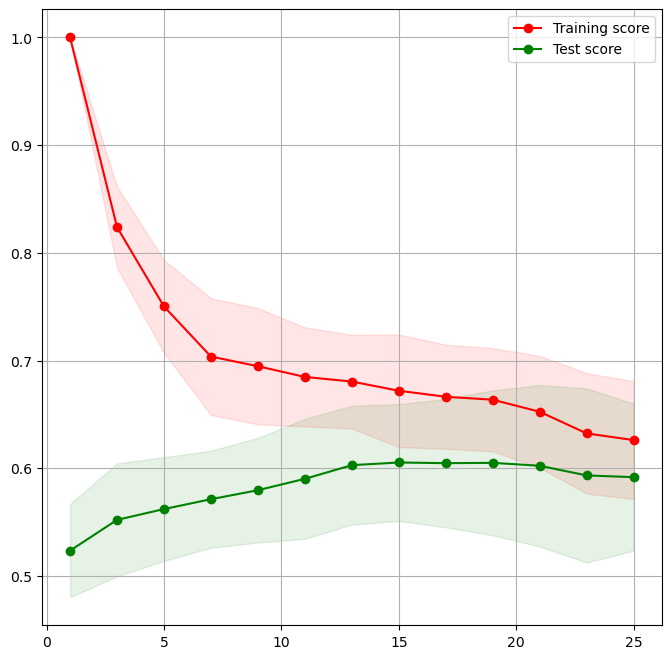

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt



k_list = list(range(1, 26, 2))
all_train = []
all_test = []

X_selected = X_clean.copy()
y = y_clean.copy()


# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.5, random_state=0)

for train_index, test_index in sss.split(X_selected, y):
    train_scores = []
    test_scores = []

    split_X_train = X_selected[train_index]
    split_y_train = y[train_index]
    split_X_test = X_selected[test_index]
    split_y_test = y[test_index]

    for k in k_list:
        clf_knn = KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        train_proba = clf_knn.predict_proba(split_X_train)[:, 1]
        test_proba = clf_knn.predict_proba(split_X_test)[:, 1]

        score_train = roc_auc_score(split_y_train, train_proba)
        score_test = roc_auc_score(split_y_test, test_proba)


        train_scores.append(score_train)
        test_scores.append(score_test)

    all_train.append(train_scores)
    all_test.append(test_scores)


# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")
ax.legend()